<a href="https://colab.research.google.com/github/sayakpaul/robustness-vit/blob/master/imagenet_results/imagenet_r/BiT_ImageNet_R_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds 

import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [ ]:
BATCH_SIZE = 32 # Reduce if ResourceExhaustedError happens
AUTO = tf.data.AUTOTUNE

In [ ]:
def preprocess_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)  
    image = tf.image.resize(image, (224, 224))
    return image, label

In [ ]:
imagenet_r = tfds.load("imagenet_r", split="test", as_supervised=True)
imagenet_r = (
    imagenet_r
    .map(preprocess_image, num_parallel_calls=True)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
image_batch, label_batch = next(iter(imagenet_r))
print(image_batch.shape, label_batch.shape)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating test examples...:   0%|          | 0/30000 [00:00<?, ? examples/s]

Shuffling imagenet_r-test.tfrecord...:   0%|          | 0/30000 [00:00<?, ? examples/s]

Dataset imagenet_r downloaded and prepared to /home/jupyter/tensorflow_datasets/imagenet_r/0.1.0. Subsequent calls will reuse this data.
(32, 224, 224, 3) (32,)


In [ ]:
module_urls = [
    "https://tfhub.dev/google/bit/m-r50x1/ilsvrc2012_classification/1",
    "https://tfhub.dev/google/bit/m-r50x3/ilsvrc2012_classification/1",
    "https://tfhub.dev/google/bit/m-r101x1/ilsvrc2012_classification/1",
    "https://tfhub.dev/google/bit/m-r101x3/ilsvrc2012_classification/1",
    "https://tfhub.dev/google/bit/m-r152x4/ilsvrc2012_classification/1"
]

In [ ]:
top_1_accs = {}
top_5_accs = {}
for module_url in tqdm(module_urls):
    variant = module_url.split("/")[5]
    print(f"Evaluating {variant}")
    imagenet_module = tf.keras.Sequential([hub.KerasLayer(module_url),
                                       tf.keras.layers.Softmax()])
    imagenet_module.compile(loss="sparse_categorical_crossentropy", 
                        metrics=[tf.keras.metrics.SparseCategoricalAccuracy(), 
                                 tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)])
    _, acc, acc_5 = imagenet_module.evaluate(imagenet_r, verbose=0)
    
    print(f"Top-1 accuracy: {acc*100}%")
    print(f"Top-5 accuracy: {acc_5*100}%")
    top_1_accs[variant] = acc
    top_5_accs[variant] = acc_5

  0%|          | 0/5 [00:00<?, ?it/s]

Evaluating m-r50x1
Top-1 accuracy: 24.8566672205925%
Top-5 accuracy: 39.836665987968445%
Evaluating m-r50x3
Top-1 accuracy: 30.43000102043152%
Top-5 accuracy: 46.50000035762787%
Evaluating m-r101x1
Top-1 accuracy: 27.250000834465027%
Top-5 accuracy: 41.89000129699707%
Evaluating m-r101x3
Top-1 accuracy: 31.443333625793457%
Top-5 accuracy: 47.45999872684479%
Evaluating m-r152x4
Top-1 accuracy: 33.7799996137619%
Top-5 accuracy: 48.88666570186615%


In [ ]:
f = open("top_1_imagnet_r_bit.pkl", "wb")
f.write(pickle.dumps(top_1_accs))
f.close()
     
f = open("top_5_imagnet_r_bit.pkl", "wb")
f.write(pickle.dumps(top_5_accs))
f.close()

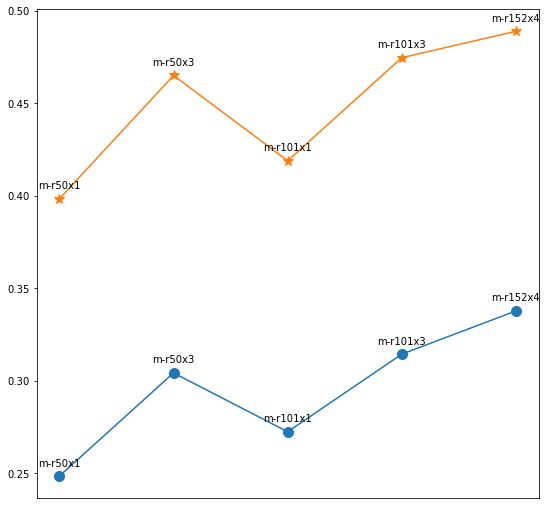

In [ ]:
plt.figure(figsize=(9, 9))
plt.plot(top_1_accs.values(), marker=".", markersize=20)
plt.plot(top_5_accs.values(), marker="*", markersize=10)
xs = np.arange(0, 5, 1)

# Reference: https://queirozf.com/entries/add-labels-and-text-to-matplotlib-plots-annotation-examples
for i, (x, y) in enumerate(zip(xs, top_1_accs.values())):
    label = list(top_1_accs.keys())[i]
    plt.annotate(label, # this is the text
         (x, y), # this is the point to label
         textcoords="offset points", # how to position the text
         xytext=(0, 10), # distance from text to points (x,y)
         ha='center') # horizontal alignment can be left, right or center
    
for i, (x, y) in enumerate(zip(xs, top_5_accs.values())):
    label = list(top_1_accs.keys())[i]
    plt.annotate(label, # this is the text
         (x, y), # this is the point to label
         textcoords="offset points", # how to position the text
         xytext=(0, 10), # distance from text to points (x,y)
         ha='center') # horizontal alignment can be left, right or center
plt.xticks([])
plt.savefig("imagenet_r_bit.png", dpi=300, bbox_inches="tight")